In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle
sys.path.append("../")
from qmg.utils import FitnessCalculator
from rdkit import RDLogger
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
from sklearn.neighbors import KernelDensity
from rdkit import Chem, DataStructs
from multiprocessing import Pool
import umap

RDLogger.DisableLog('rdApp.*')

prefix = "../results_chemistry_constraint_bo/sample_ClogP_CMR_"
data_path_list = [prefix + x for x in ["1_5_596.pkl", "2_5_599.pkl", "5_5_593.pkl", "6_5_578.pkl"]]
data_list = []
for data_path in data_path_list:
    with open(data_path, "rb") as f:
        data = pickle.load(f)
        data_list.append(data)
target_value_list = [(None, -1, 25), (None, -1, 35), (None, 1, 25), (None, 1, 35)] # ClogP and CMR
color_list = ['#1b9e77', '#d95f02', '#e7298a', '#7570b3'] # Teal, Dark orange, Magenta, Purple
# ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"] # blue, orange, green, red
target_list = ["product_validity_uniqueness", "ClogP", "CMR"]
name_list = [f"ClogP = {x}, CMR = {y}" for _, x,y in target_value_list]
target_rename_dict = {"product_validity_uniqueness": "Validity $\\times$ uniqueness (-)", "ClogP": "ClogP (-)", "CMR": r"CMR ($\mathrm{cm}^3/\mathrm{mol}$)"}
ClogP_fc = FitnessCalculator(task="ClogP")
CMR_fc =FitnessCalculator(task="CMR")

/tmp/ipykernel_850010/2581227665.py:69: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


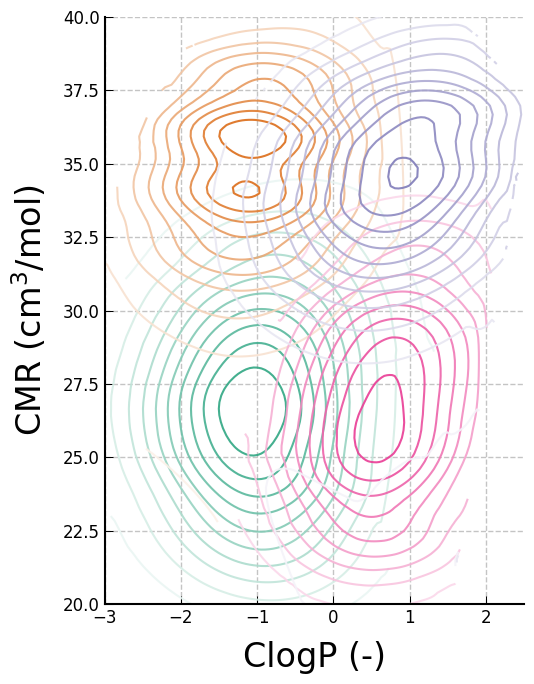

In [21]:
# Function to calculate density
def calculate_density(df, x_col, y_col):
    xy = df[[x_col, y_col]].values
    kde = KernelDensity(bandwidth=0.8, kernel='gaussian')
    kde.fit(xy)
    density = np.exp(kde.score_samples(xy))
    df['Z'] = density
    return df

# Function to create a single-color colormap
def create_single_color_cmap(color):
    return LinearSegmentedColormap.from_list("custom_cmap", ["white", color])

# Function to plot 2D contour on the same axes
def plot_2d_contours(ax, df, x_col, y_col, z_col, grid_resolution=100, cmap='#1f77b4'):
    x = df[x_col].values
    y = df[y_col].values
    z = df[z_col].values

    # Create grid data for interpolation
    xi = np.linspace(x.min(), x.max(), grid_resolution)
    yi = np.linspace(y.min(), y.max(), grid_resolution)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), method='cubic')

    # Plot contour
    contour = ax.contour(xi, yi, zi, levels=10, cmap=cmap, linewidths=1.5, alpha=0.9)
    # ax.clabel(contour, inline=True, fontsize=8, fmt='%1.1f')

# Create example DataFrames
dataframes = []
for data_dict in data_list:
    df = pd.DataFrame({'X': ClogP_fc.generate_property_distribution(data_dict), 
                       'Y': CMR_fc.generate_property_distribution(data_dict)})
    df = calculate_density(df, "X", "Y")
    dataframes.append(df)

# Adjust matplotlib parameters for Nature-style aesthetics
plt.rcParams.update({
    'font.size': 12,                # 字體大小
    'axes.labelsize': 14,          # 軸標籤字體大小
    'xtick.labelsize': 12,         # x 軸刻度字體大小
    'ytick.labelsize': 12,         # y 軸刻度字體大小
    'legend.fontsize': 12,         # 圖例字體大小
    'lines.linewidth': 3,          # 線條寬度
    'axes.linewidth': 1.5          # 坐標軸寬度
})

# Create a single plot
fig, ax = plt.subplots(figsize=(5.5, 7),constrained_layout=True)  # Adjust size for a Nature-style aspect ratio
plt.xlim(-3, 2.5)
plt.ylim(20, 40)
# Plot all contours on the same axes
for df, color in zip(dataframes, color_list):
    cmap = create_single_color_cmap(color)
    plot_2d_contours(ax, df, 'X', 'Y', 'Z', grid_resolution=100, cmap=cmap)

# Add labels and title
ax.set_xlabel("ClogP (-)", labelpad=10, fontsize=24)
ax.set_ylabel(r"CMR ($\mathrm{cm}^3/\mathrm{mol}$)", labelpad=10, fontsize=24)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customize ticks and gridlines
ax.tick_params(direction='in', length=6, width=0.75, grid_alpha=0.5)
ax.grid(visible=True, which='both', linestyle='--', linewidth=1.0, alpha=0.75)

# Set tight layout and save
plt.tight_layout()

plt.savefig('figures/distribution.svg',dpi=300, format="svg")  # Save high-resolution output
plt.show()


In [13]:
def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None
    if mol:
        fp = Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, useChirality=True)
        return np.array(fp)
    return None

def compute_single_smiles(i_smiles):
    """ Helper function to compute a single ECFP descriptor along with index """
    i, smiles = i_smiles
    ecfp = _compute_single_ecfp_descriptor(smiles)
    if ecfp is not None:
        return i, ecfp
    return None

def compute_ecfp_descriptors(smiles_list, num_workers=32):
    """ Computes ECFP descriptors using multiprocessing """
    with Pool(processes=num_workers) as pool:
        # Map the compute function to multiple processes
        results = pool.map(compute_single_smiles, enumerate(smiles_list))

    # Filter out None results and separate indices and descriptors
    valid_results = [res for res in results if res is not None]
    keep_idx = [res[0] for res in valid_results]
    descriptors = np.vstack([res[1] for res in valid_results])

    return descriptors, keep_idx

In [14]:
fps_list = []
num_points = []
tsne_df = pd.DataFrame()
for data_dict, name in zip(data_list, name_list):
    smiles_list = list(data_dict.keys())
    descriptors, keep_idx = compute_ecfp_descriptors(smiles_list)
    subdf = pd.DataFrame(descriptors, columns = [f"x{i}" for i in range(1, len(descriptors[0])+1)])
    subdf["name"] = [name]*len(descriptors)
    subdf["smiles"] = [smiles_list[i] for i in keep_idx]
    tsne_df = pd.concat([tsne_df, subdf.sample(n=1000, random_state=1)], axis=0)
    fps_list.append(descriptors)
merged_array = np.vstack(fps_list)

In [15]:
reducer = umap.UMAP(n_neighbors=30, metric="manhattan")

fp_columns = [f"x{i}" for i in range(1, len(descriptors[0])+1)]
embedding = reducer.fit_transform(tsne_df[fp_columns].values)
tsne_df["tsne 1"] = embedding[:, 0]
tsne_df["tsne 2"] = embedding[:, 1]

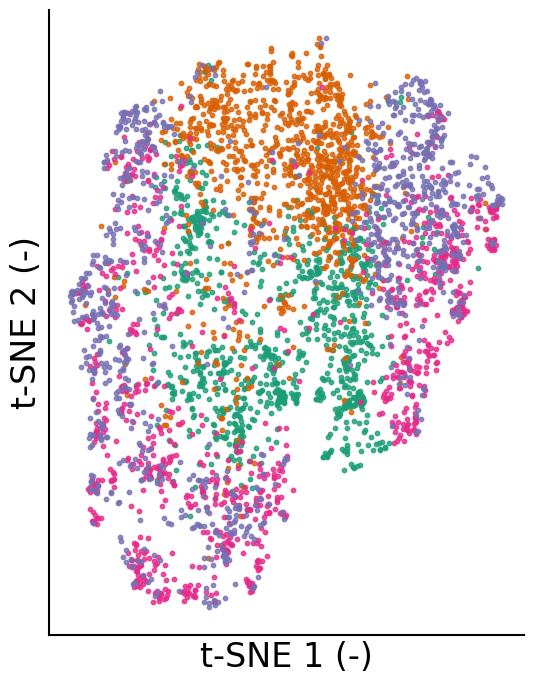

In [22]:
fig, ax = plt.subplots(figsize=(5.5, 7))
for i, (name, group) in enumerate(tsne_df.groupby("name")):
    plt.scatter(group["tsne 1"], group["tsne 2"], label=name, color=color_list[i], s=10, alpha=0.8)

# Customize the plot
plt.xlabel("t-SNE 1 (-)", fontsize=24)
plt.ylabel("t-SNE 2 (-)", fontsize=24)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
# Show the plot
plt.tight_layout()
plt.savefig('figures/tsne.svg',dpi=300, format="svg")  # Save high-resolution output
plt.show()